# The Battle of Neighborhoods

## New York crime data point of view

### Introduction
In the week 2 of the IBM Data Science Capstone Project course our task was to cluster Manhatten neighborhoods based on Foursquare data. So let's do it a bit differently. What would result look like if we use NYPD data? 

In [1]:
import numpy as np

import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from math import sin, cos, sqrt, atan2, radians

print('Libraries imported.')

Libraries imported.


## Data acquisition and cleaning

For tis project we will be using and combining multiple data sources.

### Data sources

#### Neighborhoods

In [2]:
!wget -q -O newyork_data.json https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#### Crime Data

In [4]:
!wget -q -O NYPD_Complaint_Current.json https://data.cityofnewyork.us/resource/5uac-w243.json


with open('NYPD_Complaint_Current.json') as json_data:
    complaint_data = json.load(json_data)

In [5]:
!wget -q -O NYPD_Arrest_Data.json https://data.cityofnewyork.us/resource/uip8-fykc.json
    
with open('NYPD_Arrest_Data.json') as json_data:
    arrest_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [8]:
complaint_data[0]

{'cmplnt_num': '885776788',
 'addr_pct_cd': '66',
 'cmplnt_fr_dt': '2020-12-23T00:00:00.000',
 'cmplnt_fr_tm': '19:50:00',
 'crm_atpt_cptd_cd': 'COMPLETED',
 'juris_desc': 'N.Y. POLICE DEPT',
 'ky_cd': '101',
 'law_cat_cd': 'FELONY',
 'loc_of_occur_desc': 'OUTSIDE',
 'ofns_desc': 'MURDER & NON-NEGL. MANSLAUGHTER',
 'rpt_dt': '2020-12-23T00:00:00.000',
 'vic_age_group': '18-24',
 'vic_race': 'BLACK',
 'vic_sex': 'M',
 'x_coord_cd': '986633',
 'y_coord_cd': '167258',
 'latitude': '40.62576896100006',
 'longitude': '-73.99141682199996',
 'lat_lon': {'latitude': '40.62576896100006',
  'longitude': '-73.99141682199996'},
 'geocoded_column': {'type': 'Point',
  'coordinates': [-73.99141682199996, 40.62576896100006]},
 ':@computed_region_efsh_h5xi': '17621',
 ':@computed_region_f5dn_yrer': '2',
 ':@computed_region_yeji_bk3q': '2',
 ':@computed_region_92fq_4b7q': '18',
 ':@computed_region_sbqj_enih': '39'}

In [9]:
arrest_data[0]

{'arrest_key': '222243929',
 'arrest_date': '2020-12-25T00:00:00.000',
 'pd_cd': '105',
 'pd_desc': 'STRANGULATION 1ST',
 'ky_cd': '106.0',
 'ofns_desc': 'FELONY ASSAULT',
 'law_code': 'PL 1211200',
 'law_cat_cd': 'F',
 'arrest_boro': 'B',
 'arrest_precinct': '40',
 'jurisdiction_code': '0',
 'age_group': '25-44',
 'perp_sex': 'M',
 'perp_race': 'BLACK',
 'x_coord_cd': '1007453',
 'y_coord_cd': '233952',
 'latitude': '40.80879780500004',
 'longitude': '-73.91618413199996',
 'geocoded_column': {'type': 'Point',
  'coordinates': [-73.91618413199996, 40.80879780500004]},
 ':@computed_region_f5dn_yrer': '49',
 ':@computed_region_yeji_bk3q': '5',
 ':@computed_region_92fq_4b7q': '35',
 ':@computed_region_sbqj_enih': '23',
 ':@computed_region_efsh_h5xi': '10932'}

#### Venues

In [10]:
CLIENT_ID = 'W3MOAZ5RCIAK5LGYE2HVVFJRZ53ADOK5N5E1TOZWMKZPQVWX' # your Foursquare ID
CLIENT_SECRET = 'CPLBP1DHYCHTJD0KMAC4WQJUC2RLUIGPYERBF1KJYN1YN1KL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W3MOAZ5RCIAK5LGYE2HVVFJRZ53ADOK5N5E1TOZWMKZPQVWX
CLIENT_SECRET:CPLBP1DHYCHTJD0KMAC4WQJUC2RLUIGPYERBF1KJYN1YN1KL


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Data cleaning

#### Neighborhoods

In [12]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

In [13]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [14]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
neighborhoods.shape

(70, 4)

In [16]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [17]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 1 boroughs and 70 neighborhoods.


#### Crime data

In [18]:
column_names_complaint = ['Offense', 'Latitude', 'Longitude']
complaint = pd.DataFrame(columns=column_names_complaint)

In [19]:
for data in complaint_data:
           
    try:
        offense = data['ofns_desc'] 
    except:
        offense = None
    
    complaint_latlon = data['geocoded_column']['coordinates']
    complaint_lat = complaint_latlon[1]
    complaint_lon = complaint_latlon[0]
    
    complaint = complaint.append({'Offense': offense,
                                          'Latitude': complaint_lat,
                                          'Longitude': complaint_lon}, ignore_index=True)

In [20]:
complaint.head()

,Offense,Latitude,Longitude
0,MURDER & NON-NEGL. MANSLAUGHTER,40.625769,-73.991417
1,MURDER & NON-NEGL. MANSLAUGHTER,40.674583,-73.930222
2,RAPE,40.823101,-73.869690
3,MURDER & NON-NEGL. MANSLAUGHTER,40.887451,-73.847608
4,MURDER & NON-NEGL. MANSLAUGHTER,40.800222,-73.930848


In [21]:
column_names_arrest = ['Offense', 'Latitude', 'Longitude']
arrest = pd.DataFrame(columns=column_names_arrest)

In [22]:
for data in arrest_data:
        
    try:
        offense = data['ofns_desc'] 
    except:
        offense = None
    
    complaint_latlon = data['geocoded_column']['coordinates']
    complaint_lat = complaint_latlon[1]
    complaint_lon = complaint_latlon[0]
    
    arrest = arrest.append({'Offense': offense,
                                          'Latitude': complaint_lat,
                                          'Longitude': complaint_lon}, ignore_index=True)

In [23]:
arrest.head()

,Offense,Latitude,Longitude
0,FELONY ASSAULT,40.808798,-73.916184
1,ROBBERY,40.845956,-73.937813
2,FELONY ASSAULT,40.682398,-73.840079
3,FELONY ASSAULT,40.689336,-73.800409
4,FORGERY,40.634708,-74.124241


In [24]:
def wgs84_distance(point1, point2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(point1[0])
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #print("Result:", distance)
    
    return distance

In [25]:
complaint_neighborhood = []
for r_no,row in complaint.iterrows(): 
    dist_dict = dict()
    for nbh_no, nbh in neighborhoods.iterrows():
        distance = wgs84_distance([nbh['Latitude'],nbh['Longitude']],[row['Latitude'],row['Longitude']])
        dist_dict[nbh['Neighborhood']] = distance
    complaint_neighborhood.append(min(dist_dict, key = dist_dict.get))

complaint['Neighborhood'] = complaint_neighborhood
complaint.head()

,Offense,Latitude,Longitude,Neighborhood
0,MURDER & NON-NEGL. MANSLAUGHTER,40.625769,-73.991417,Borough Park
1,MURDER & NON-NEGL. MANSLAUGHTER,40.674583,-73.930222,Weeksville
2,RAPE,40.823101,-73.869690,Greenpoint
3,MURDER & NON-NEGL. MANSLAUGHTER,40.887451,-73.847608,Greenpoint
4,MURDER & NON-NEGL. MANSLAUGHTER,40.800222,-73.930848,Greenpoint


In [26]:
arrest_neighborhood = []
for r_no,row in arrest.iterrows(): 
    dist_dict = dict()
    for nbh_no, nbh in neighborhoods.iterrows():
        distance = wgs84_distance([nbh['Latitude'],nbh['Longitude']],[row['Latitude'],row['Longitude']])
        dist_dict[nbh['Neighborhood']] = distance
    arrest_neighborhood.append(min(dist_dict, key = dist_dict.get))

arrest['Neighborhood'] = arrest_neighborhood
arrest.head()

,Offense,Latitude,Longitude,Neighborhood
0,FELONY ASSAULT,40.808798,-73.916184,Greenpoint
1,ROBBERY,40.845956,-73.937813,Greenpoint
2,FELONY ASSAULT,40.682398,-73.840079,City Line
3,FELONY ASSAULT,40.689336,-73.800409,City Line
4,FORGERY,40.634708,-74.124241,Bay Ridge


In [27]:
arrest_complaint_df = pd.concat([arrest, complaint])

In [28]:
arrest_complaint_onehot = pd.get_dummies(arrest_complaint_df[['Offense']], prefix="", prefix_sep="")
arrest_complaint_onehot['Neighborhood'] = arrest_complaint_df['Neighborhood'] 

# move neighborhood column to the first column
col_names = list(arrest_complaint_onehot.columns[:])
col_names.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + col_names

arrest_complaint_onehot = arrest_complaint_onehot[fixed_columns]

In [29]:
arrest_complaint_grouped = arrest_complaint_onehot.groupby('Neighborhood').mean().reset_index()
arrest_complaint_grouped

,Neighborhood,ADMINISTRATIVE CODE,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,Bath Beach,0.0,0.0,0.0,0.0,0.428571,0.0,0.000000,0.142857,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000
1,Bay Ridge,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.166667,0.027778,...,0.194444,0.0,0.0,0.027778,0.000000,0.000000,0.0,0.0000,0.0,0.000000
2,Bedford Stuyvesant,0.0,0.0,0.0,0.0,0.068966,0.0,0.034483,0.172414,0.000000,...,0.068966,0.0,0.0,0.000000,0.103448,0.000000,0.0,0.0000,0.0,0.034483
3,Bensonhurst,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.125000,0.000000,...,0.125000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000
4,Bergen Beach,0.0,0.0,0.0,0.0,0.363636,0.0,0.000000,0.090909,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.0000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vinegar Hill,0.0,0.0,0.0,0.0,0.133333,0.0,0.000000,0.133333,0.000000,...,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000
66,Weeksville,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.111111,0.000000,...,0.000000,0.0,0.0,0.074074,0.074074,0.074074,0.0,0.0000,0.0,0.074074
67,Williamsburg,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.000000,0.000000,...,0.200000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000
68,Windsor Terrace,0.0,0.0,0.0,0.0,0.166667,0.0,0.166667,0.166667,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000


In [30]:
def return_most_common_characteristic(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_offenses = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_offenses):
    try:
        columns.append('{}{} Most Common Offense'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Offense'.format(ind+1))

# create a new dataframe
neighborhoods_offense_sorted = pd.DataFrame(columns=columns)
neighborhoods_offense_sorted['Neighborhood'] = arrest_complaint_grouped['Neighborhood']

for ind in np.arange(arrest_complaint_grouped.shape[0]):
    neighborhoods_offense_sorted.iloc[ind, 1:] = return_most_common_characteristic(arrest_complaint_grouped.iloc[ind, :], num_top_offenses)

neighborhoods_offense_sorted.head()

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
0,Bath Beach,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,MISCELLANEOUS PENAL LAW,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT
1,Bay Ridge,PETIT LARCENY,CRIMINAL MISCHIEF & RELATED OF,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,MISCELLANEOUS PENAL LAW
2,Bedford Stuyvesant,CRIMINAL MISCHIEF & RELATED OF,MISCELLANEOUS PENAL LAW,ROBBERY,FELONY ASSAULT,GRAND LARCENY
3,Bensonhurst,FELONY ASSAULT,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,CRIMINAL MISCHIEF & RELATED OF,PETIT LARCENY
4,Bergen Beach,ASSAULT 3 & RELATED OFFENSES,GRAND LARCENY,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTE,MURDER & NON-NEGL. MANSLAUGHTER


#### Venues

In [32]:
neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [33]:
neighborhoods_onehot = pd.get_dummies(neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")
neighborhoods_onehot['Neighborhood'] = neighborhoods_venues['Neighborhood'] 

# move neighborhood column to the first column
col_names = list(neighborhoods_onehot.columns[:])
col_names.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + col_names

neighborhoods_onehot = neighborhoods_onehot[fixed_columns]

In [34]:
neighborhoods_onehot.head()

,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
neighborhoods_grouped = neighborhoods_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_grouped

,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bath Beach,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.020000,0.02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,Bay Ridge,0.0,0.0,0.036585,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.012195,0.00,0.012195,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,Bedford Stuyvesant,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.033333,0.033333,0.0,0.0,0.000000
3,Bensonhurst,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,Bergen Beach,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vinegar Hill,0.0,0.0,0.033333,0.000000,0.0,0.0,0.066667,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.000000
66,Weeksville,0.0,0.0,0.071429,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
67,Williamsburg,0.0,0.0,0.000000,0.000000,0.0,0.0,0.029412,0.000000,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.029412,0.000000,0.0,0.0,0.029412
68,Windsor Terrace,0.0,0.0,0.034483,0.034483,0.0,0.0,0.000000,0.034483,0.0,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.034483,0.0,0.0,0.000000


In [36]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhoods_grouped['Neighborhood']

for ind in np.arange(neighborhoods_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_characteristic(neighborhoods_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bath Beach,Chinese Restaurant,Pharmacy,Donut Shop,Bubble Tea Shop,Cantonese Restaurant
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,Chinese Restaurant
2,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Deli / Bodega,Bar
3,Bensonhurst,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Italian Restaurant
4,Bergen Beach,Harbor / Marina,Park,Athletics & Sports,Baseball Field,Playground


### Clustering

#### Crime

In [37]:
arrest_complaint_gouped_clustering = arrest_complaint_grouped.drop('Neighborhood', 1)

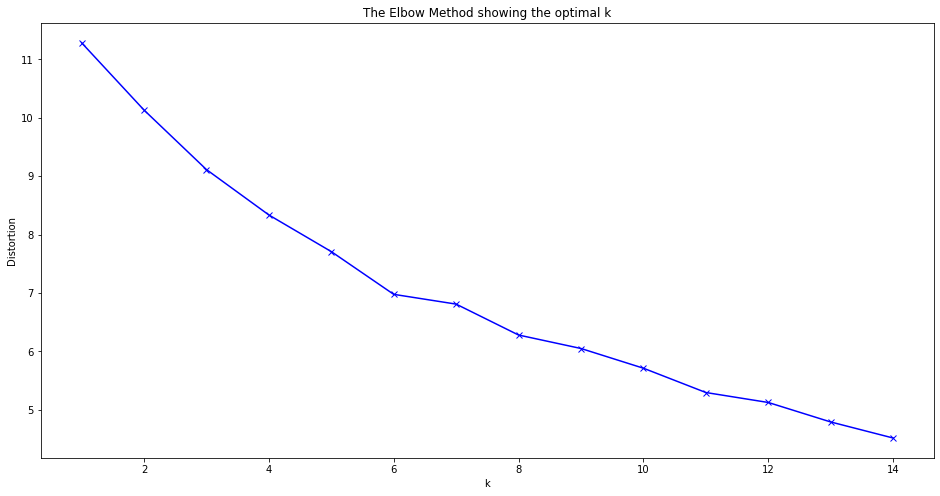

In [38]:
distortions = []
K = range(1,15)
for k in K:
    kmeanElbowModel = KMeans(n_clusters=k, random_state=0)
    kmeanElbowModel.fit(arrest_complaint_gouped_clustering)
    distortions.append(kmeanElbowModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Venues

In [39]:
neighborhoods_grouped_clustering = neighborhoods_grouped.drop('Neighborhood', 1)

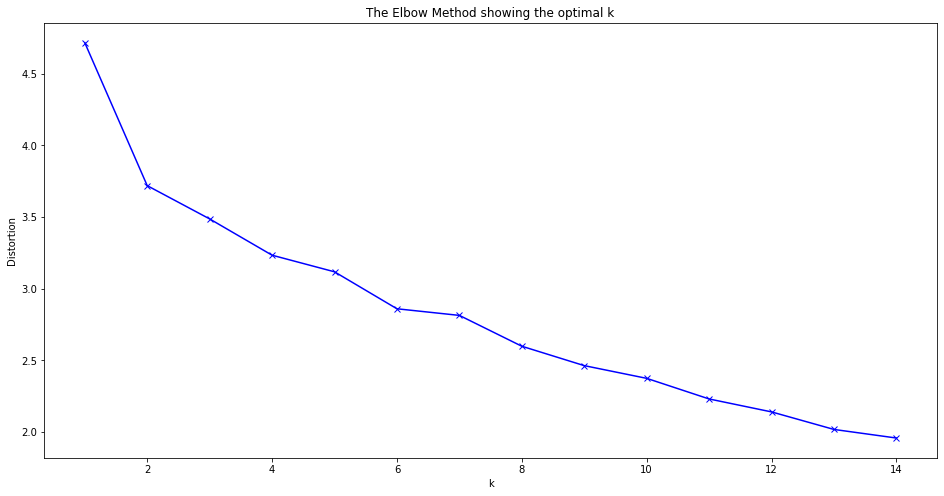

In [40]:
distortions = []
K = range(1,15)
for k in K:
    kmeanElbowModel = KMeans(n_clusters=k, random_state=0)
    kmeanElbowModel.fit(neighborhoods_grouped_clustering)
    distortions.append(kmeanElbowModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Final Calculation

In [41]:
kclusters_crime = 6


# run k-means clustering
kmeans_crime = KMeans(n_clusters=kclusters_crime, random_state=0).fit(arrest_complaint_gouped_clustering)

# check cluster labels generated for each row in the dataframe
len(kmeans_crime.labels_)

70

In [42]:
kclusters_venues = 6



# run k-means clustering
kmeans_venues = KMeans(n_clusters=kclusters_venues, random_state=0).fit(neighborhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
len(kmeans_venues.labels_)

70

In [43]:
# add clustering labels
neighborhoods_offense_sorted.insert(0, 'Cluster Labels', kmeans_crime.labels_)

In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_venues.labels_)

In [45]:
#places_df['Cluster Labels'] = places_df['Cluster Labels'].astype(int)
#places_df[['Cluster Labels','Neighborhood']].values
#arrest_complaint_grouped['Neighborhood'].isin(['Howland Hook']).values

In [46]:
neighborhoods_merged = neighborhoods

In [47]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
neighborhoods_crime_merged = neighborhoods_merged.join(neighborhoods_offense_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'inner')

neighborhoods_crime_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
0,Brooklyn,Bay Ridge,40.625801,-74.030621,2,PETIT LARCENY,CRIMINAL MISCHIEF & RELATED OF,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,MISCELLANEOUS PENAL LAW
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1,FELONY ASSAULT,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,CRIMINAL MISCHIEF & RELATED OF,PETIT LARCENY
2,Brooklyn,Sunset Park,40.645103,-74.010316,2,PETIT LARCENY,ASSAULT 3 & RELATED OFFENSES,VEHICLE AND TRAFFIC LAWS,OFF. AGNST PUB ORD SENSBLTY &,CRIMINAL MISCHIEF & RELATED OF
3,Brooklyn,Greenpoint,40.730201,-73.954241,2,ASSAULT 3 & RELATED OFFENSES,PETIT LARCENY,FELONY ASSAULT,CRIMINAL MISCHIEF & RELATED OF,HARRASSMENT 2
4,Brooklyn,Gravesend,40.595260,-73.973471,1,CRIMINAL MISCHIEF & RELATED OF,PETIT LARCENY,FELONY ASSAULT,VEHICLE AND TRAFFIC LAWS,DANGEROUS WEAPONS


In [48]:
neighborhoods_merged = neighborhoods

In [49]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
neighborhoods_venues_merged = neighborhoods_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'inner')

neighborhoods_venues_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,Chinese Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,5,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Italian Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,5,Bank,Bakery,Mexican Restaurant,Latin American Restaurant,Pizza Place
3,Brooklyn,Greenpoint,40.730201,-73.954241,4,Pizza Place,Coffee Shop,Bar,Cocktail Bar,Grocery Store
4,Brooklyn,Gravesend,40.595260,-73.973471,5,Pizza Place,Italian Restaurant,Lounge,Chinese Restaurant,Bus Station


In [50]:
neighborhoods_crime_merged[['Cluster Labels','Neighborhood']].values

array([[2, 'Bay Ridge'],
       [1, 'Bensonhurst'],
       [2, 'Sunset Park'],
       [2, 'Greenpoint'],
       [1, 'Gravesend'],
       [2, 'Brighton Beach'],
       [0, 'Sheepshead Bay'],
       [3, 'Manhattan Terrace'],
       [0, 'Flatbush'],
       [2, 'Crown Heights'],
       [0, 'East Flatbush'],
       [2, 'Kensington'],
       [0, 'Windsor Terrace'],
       [2, 'Prospect Heights'],
       [2, 'Brownsville'],
       [3, 'Williamsburg'],
       [2, 'Bushwick'],
       [2, 'Bedford Stuyvesant'],
       [2, 'Brooklyn Heights'],
       [1, 'Cobble Hill'],
       [3, 'Carroll Gardens'],
       [2, 'Red Hook'],
       [3, 'Gowanus'],
       [3, 'Fort Greene'],
       [3, 'Park Slope'],
       [2, 'Cypress Hills'],
       [2, 'East New York'],
       [1, 'Starrett City'],
       [1, 'Canarsie'],
       [2, 'Flatlands'],
       [5, 'Mill Island'],
       [3, 'Manhattan Beach'],
       [2, 'Coney Island'],
       [0, 'Bath Beach'],
       [2, 'Borough Park'],
       [2, 'Dyker Heights']

In [51]:
neighborhoods_venues_merged[['Cluster Labels','Neighborhood']].values

array([[4, 'Bay Ridge'],
       [5, 'Bensonhurst'],
       [5, 'Sunset Park'],
       [4, 'Greenpoint'],
       [5, 'Gravesend'],
       [5, 'Brighton Beach'],
       [4, 'Sheepshead Bay'],
       [2, 'Manhattan Terrace'],
       [5, 'Flatbush'],
       [4, 'Crown Heights'],
       [5, 'East Flatbush'],
       [2, 'Kensington'],
       [4, 'Windsor Terrace'],
       [4, 'Prospect Heights'],
       [5, 'Brownsville'],
       [4, 'Williamsburg'],
       [4, 'Bushwick'],
       [4, 'Bedford Stuyvesant'],
       [4, 'Brooklyn Heights'],
       [4, 'Cobble Hill'],
       [4, 'Carroll Gardens'],
       [4, 'Red Hook'],
       [4, 'Gowanus'],
       [4, 'Fort Greene'],
       [4, 'Park Slope'],
       [5, 'Cypress Hills'],
       [5, 'East New York'],
       [5, 'Starrett City'],
       [0, 'Canarsie'],
       [5, 'Flatlands'],
       [3, 'Mill Island'],
       [2, 'Manhattan Beach'],
       [5, 'Coney Island'],
       [5, 'Bath Beach'],
       [5, 'Borough Park'],
       [4, 'Dyker Heights']

### Results

#### Crime

In [68]:
# create map
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_crime)
ys = [i + x + (i*x)**2 for i in range(kclusters_crime)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_crime_merged['Latitude'], neighborhoods_crime_merged['Longitude'], neighborhoods_crime_merged['Neighborhood'], neighborhoods_crime_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' => Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [54]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 0, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
6,Sheepshead Bay,HARRASSMENT 2,ASSAULT 3 & RELATED OFFENSES,BURGLARY,VEHICLE AND TRAFFIC LAWS,FELONY ASSAULT
8,Flatbush,ASSAULT 3 & RELATED OFFENSES,GRAND LARCENY,BURGLARY,CRIMINAL TRESPASS,VEHICLE AND TRAFFIC LAWS
10,East Flatbush,HARRASSMENT 2,GRAND LARCENY OF MOTOR VEHICLE,BURGLARY,ASSAULT 3 & RELATED OFFENSES,UNAUTHORIZED USE OF A VEHICLE
12,Windsor Terrace,DANGEROUS WEAPONS,HARRASSMENT 2,ASSAULT 3 & RELATED OFFENSES,BURGLARY,CRIMINAL MISCHIEF & RELATED OF
33,Bath Beach,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,MISCELLANEOUS PENAL LAW,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT
37,Marine Park,ASSAULT 3 & RELATED OFFENSES,OFF. AGNST PUB ORD SENSBLTY &,OTHER TRAFFIC INFRACTION,VEHICLE AND TRAFFIC LAWS,FELONY ASSAULT
45,Bergen Beach,ASSAULT 3 & RELATED OFFENSES,GRAND LARCENY,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTE,MURDER & NON-NEGL. MANSLAUGHTER
46,Midwood,ASSAULT 3 & RELATED OFFENSES,BURGLARY,VEHICLE AND TRAFFIC LAWS,FELONY ASSAULT,"HOMICIDE-NEGLIGENT,UNCLASSIFIE"
56,Rugby,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,FELONY ASSAULT,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER


In [55]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 1, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
1,Bensonhurst,FELONY ASSAULT,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,CRIMINAL MISCHIEF & RELATED OF,PETIT LARCENY
4,Gravesend,CRIMINAL MISCHIEF & RELATED OF,PETIT LARCENY,FELONY ASSAULT,VEHICLE AND TRAFFIC LAWS,DANGEROUS WEAPONS
19,Cobble Hill,FELONY ASSAULT,MISCELLANEOUS PENAL LAW,ARSON,PETIT LARCENY,VEHICLE AND TRAFFIC LAWS
27,Starrett City,PETIT LARCENY,MURDER & NON-NEGL. MANSLAUGHTER,ASSAULT 3 & RELATED OFFENSES,FELONY ASSAULT,HARRASSMENT 2
28,Canarsie,HARRASSMENT 2,MURDER & NON-NEGL. MANSLAUGHTER,PETIT LARCENY,FELONY ASSAULT,VEHICLE AND TRAFFIC LAWS
41,Boerum Hill,HARRASSMENT 2,PETIT LARCENY,MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,DANGEROUS WEAPONS
52,Ocean Parkway,PETIT LARCENY,HARRASSMENT 2,DANGEROUS WEAPONS,ROBBERY,OFF. AGNST PUB ORD SENSBLTY &
54,Ditmas Park,PETIT LARCENY,DANGEROUS WEAPONS,HARRASSMENT 2,GRAND LARCENY OF MOTOR VEHICLE,ASSAULT 3 & RELATED OFFENSES
62,Vinegar Hill,PETIT LARCENY,ASSAULT 3 & RELATED OFFENSES,MURDER & NON-NEGL. MANSLAUGHTER,CRIMINAL MISCHIEF & RELATED OF,HARRASSMENT 2
66,Homecrest,PETIT LARCENY,DANGEROUS DRUGS,FELONY ASSAULT,DANGEROUS WEAPONS,HARRASSMENT 2


In [56]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 2, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
0,Bay Ridge,PETIT LARCENY,CRIMINAL MISCHIEF & RELATED OF,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,MISCELLANEOUS PENAL LAW
2,Sunset Park,PETIT LARCENY,ASSAULT 3 & RELATED OFFENSES,VEHICLE AND TRAFFIC LAWS,OFF. AGNST PUB ORD SENSBLTY &,CRIMINAL MISCHIEF & RELATED OF
3,Greenpoint,ASSAULT 3 & RELATED OFFENSES,PETIT LARCENY,FELONY ASSAULT,CRIMINAL MISCHIEF & RELATED OF,HARRASSMENT 2
5,Brighton Beach,DANGEROUS DRUGS,FELONY ASSAULT,GRAND LARCENY OF MOTOR VEHICLE,ROBBERY,ASSAULT 3 & RELATED OFFENSES
9,Crown Heights,ASSAULT 3 & RELATED OFFENSES,BURGLARY,SEX CRIMES,CRIMINAL MISCHIEF & RELATED OF,DANGEROUS WEAPONS
11,Kensington,ROBBERY,FELONY ASSAULT,ASSAULT 3 & RELATED OFFENSES,GRAND LARCENY,PETIT LARCENY
13,Prospect Heights,HARRASSMENT 2,ROBBERY,PETIT LARCENY,CRIMINAL MISCHIEF & RELATED OF,VEHICLE AND TRAFFIC LAWS
14,Brownsville,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER
16,Bushwick,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,ROBBERY,PETIT LARCENY,ASSAULT 3 & RELATED OFFENSES
17,Bedford Stuyvesant,CRIMINAL MISCHIEF & RELATED OF,MISCELLANEOUS PENAL LAW,ROBBERY,FELONY ASSAULT,GRAND LARCENY


In [57]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 3, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
7,Manhattan Terrace,PETIT LARCENY,GRAND LARCENY,VEHICLE AND TRAFFIC LAWS,DANGEROUS WEAPONS,HARRASSMENT 2
15,Williamsburg,HARRASSMENT 2,MURDER & NON-NEGL. MANSLAUGHTER,BURGLARY,PETIT LARCENY,DANGEROUS WEAPONS
20,Carroll Gardens,GRAND LARCENY,PETIT LARCENY,MURDER & NON-NEGL. MANSLAUGHTER,BURGLARY,VEHICLE AND TRAFFIC LAWS
22,Gowanus,DANGEROUS DRUGS,GRAND LARCENY,BURGLARY,PETIT LARCENY,DANGEROUS WEAPONS
23,Fort Greene,MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,GRAND LARCENY,DANGEROUS DRUGS,VEHICLE AND TRAFFIC LAWS
24,Park Slope,MISCELLANEOUS PENAL LAW,GRAND LARCENY,MURDER & NON-NEGL. MANSLAUGHTER,PETIT LARCENY,VEHICLE AND TRAFFIC LAWS
31,Manhattan Beach,GRAND LARCENY,OFFENSES AGAINST THE PERSON,VEHICLE AND TRAFFIC LAWS,INTOXICATED & IMPAIRED DRIVING,HARRASSMENT 2
40,Downtown,PETIT LARCENY,GRAND LARCENY,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,MISCELLANEOUS PENAL LAW
50,North Side,BURGLARY,HARRASSMENT 2,PETIT LARCENY,GRAND LARCENY,FELONY ASSAULT
60,Mill Basin,HARRASSMENT 2,GRAND LARCENY,PETIT LARCENY,INTOXICATED & IMPAIRED DRIVING,VEHICLE AND TRAFFIC LAWS


In [58]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 4, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
51,South Side,HARRASSMENT 2,VEHICLE AND TRAFFIC LAWS,UNAUTHORIZED USE OF A VEHICLE,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",GRAND LARCENY OF MOTOR VEHICLE


In [59]:
neighborhoods_crime_merged.loc[neighborhoods_crime_merged['Cluster Labels'] == 5, neighborhoods_crime_merged.columns[[1] + list(range(5, neighborhoods_crime_merged.shape[1]))]]

,Neighborhood,1st Most Common Offense,2nd Most Common Offense,3rd Most Common Offense,4th Most Common Offense,5th Most Common Offense
30,Mill Island,FELONY ASSAULT,VEHICLE AND TRAFFIC LAWS,UNAUTHORIZED USE OF A VEHICLE,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",HARRASSMENT 2
36,Gerritsen Beach,VEHICLE AND TRAFFIC LAWS,FELONY ASSAULT,ASSAULT 3 & RELATED OFFENSES,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",HARRASSMENT 2
48,Georgetown,FELONY ASSAULT,ASSAULT 3 & RELATED OFFENSES,VEHICLE AND TRAFFIC LAWS,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",HARRASSMENT 2


#### Venues

In [69]:
# create map
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_venues)
ys = [i + x + (i*x)**2 for i in range(kclusters_venues)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_merged['Latitude'], neighborhoods_venues_merged['Longitude'], neighborhoods_venues_merged['Neighborhood'], neighborhoods_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' => Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [60]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 0, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
28,Canarsie,Asian Restaurant,Food,Grocery Store,Caribbean Restaurant,Home Service
59,Paerdegat Basin,Child Care Service,Food,Home Service,Asian Restaurant,Gym


In [61]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 1, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
45,Bergen Beach,Harbor / Marina,Park,Athletics & Sports,Baseball Field,Playground


In [62]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 2, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Manhattan Terrace,Pizza Place,Ice Cream Shop,Cosmetics Shop,Donut Shop,Liquor Store
11,Kensington,Thai Restaurant,Grocery Store,Pizza Place,Ice Cream Shop,Park
31,Manhattan Beach,Bus Stop,Ice Cream Shop,Playground,Sandwich Place,Harbor / Marina
43,Ocean Hill,Deli / Bodega,Grocery Store,Southern / Soul Food Restaurant,Supermarket,Fried Chicken Joint
46,Midwood,Pizza Place,Convenience Store,Ice Cream Shop,Candy Store,Bakery
67,Highland Park,Liquor Store,Spanish Restaurant,Pizza Place,Grocery Store,Latin American Restaurant


In [63]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 3, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
30,Mill Island,Pool,Yoga Studio,Fish Market,Farm,Farmers Market


In [64]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 4, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,Chinese Restaurant
3,Greenpoint,Pizza Place,Coffee Shop,Bar,Cocktail Bar,Grocery Store
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Yoga Studio,Karaoke Bar,Hotel
9,Crown Heights,Pizza Place,Café,Museum,Bagel Shop,Burger Joint
12,Windsor Terrace,Deli / Bodega,Plaza,Grocery Store,Park,Diner
13,Prospect Heights,Bar,Mexican Restaurant,Cocktail Bar,Wine Shop,Coffee Shop
15,Williamsburg,Pizza Place,Coffee Shop,Bagel Shop,Yoga Studio,Event Space
16,Bushwick,Bar,Coffee Shop,Mexican Restaurant,Deli / Bodega,Discount Store
17,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Deli / Bodega,Bar
18,Brooklyn Heights,Deli / Bodega,Yoga Studio,Park,Coffee Shop,Gym


In [65]:
neighborhoods_venues_merged.loc[neighborhoods_venues_merged['Cluster Labels'] == 5, neighborhoods_venues_merged.columns[[1] + list(range(5, neighborhoods_venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Italian Restaurant
2,Sunset Park,Bank,Bakery,Mexican Restaurant,Latin American Restaurant,Pizza Place
4,Gravesend,Pizza Place,Italian Restaurant,Lounge,Chinese Restaurant,Bus Station
5,Brighton Beach,Restaurant,Russian Restaurant,Eastern European Restaurant,Gourmet Shop,Mobile Phone Shop
8,Flatbush,Deli / Bodega,Mexican Restaurant,Coffee Shop,Caribbean Restaurant,Bank
10,East Flatbush,Chinese Restaurant,Print Shop,Supermarket,Caribbean Restaurant,Park
14,Brownsville,Fried Chicken Joint,Moving Target,Restaurant,Plaza,Convenience Store
25,Cypress Hills,Fried Chicken Joint,Spanish Restaurant,Donut Shop,Fast Food Restaurant,Pizza Place
26,East New York,Deli / Bodega,Spanish Restaurant,Fast Food Restaurant,Food Truck,Metro Station
27,Starrett City,Bus Station,Convenience Store,Pharmacy,American Restaurant,Caribbean Restaurant
